# Problem 10.1: Lossy Compression With a Variational Autoencoder (VAE)

**Course:** Data Compression With And Without Deep probabilistic models (Prof. Robert Bamler at University of Tuebingen)

- This notebook is part of Problem Set 10, published on 8 June 2022 and discussed on 15 June 2022.
- You can download the full problem set (and solutions) from the [course website](https://robamler.github.io/teaching/compress22/).

This problem guides you through the implementation of a lossy compression scheme for hand-written digits (MNIST).
We'll use a Variational Autoencoder (VAE) and the quantization method introduced in [Ballé et al., "End-to-end optimized image compression" (ICLR 2017)](https://openreview.net/forum?id=rJxdQ3jeg).
The VAE is similar to the one you implemented on the last problem set, but you can solve both problem sets independently.

## Setup

Same as on the last problem set:
let's load some libraries, set some global configurations, and load the training and test sets.

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import time

/home/robamler/Dropbox/teaching/compress22/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
USE_CUDA = False # change to True if you have a compatible GPU
RANDOM_SEED = 20220625
BATCH_SIZE = 100
EPOCHS = 50
BATCHES_BETWEEN_LOGGING = 100
LATENT_DIM = 8

In [3]:
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

## Visualize some of the training data

Same as on the last problem set:
the training data consists of black-and-white handwritten digits with a resolution of 28x28 pixels.

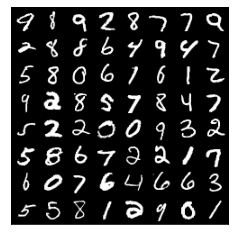

In [5]:
for batch, _ in train_loader:
    ax = plt.imshow(make_grid(batch[:64]).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    break

## Encoder and Decoder Model

Here's where things start to differ from the last problem set.

The classes `Encoder` and `Decoder` define again two neural networks.
However, this time, the variational distribution (whose parameters are the output of the encoder network) is a uniform distribution with a fixed width.
Thus:

- `Encoder` is a neural network with weights $\phi$.
  It takes a batch of images $x$ as input and outputs a vector $\mu_\phi(x)$ that lives in the latent representation space.
  This vector parameterizes the variational distribution $Q_\phi(Z\,|\,X\!=\!x)$, which is a *uniform* (continuous) distribution over a hypercube of width 1 that is centered around $\mu_\phi(x)$.
  This means that the probability density $Q_\phi(Z\!=\!z\,|\,X\!=\!x)$ is constant (one) for all points $z$ that satisfy $|z_i-\mu_\phi(x)\leq \frac12|$ for all coordinates $i$, and the density is zero everywhere else.
- `Decoder` is the same as on the last problem set.
  It is a neural network with weights $\theta$ that takes a latent representation $z$ as input and outputs the parameters $\hat x_\theta(z)$ of the likelihood $P_\theta(X\,|\,Z\!=\!z)$.
  Here, we model the likelihood $P_\theta(X\,|\,Z\!=\!z)$ as a Bernoulli distribution, which is a fancy way of saying that each pixel $X_i$ can be either black or white, and it is white with probability $\hat x_\theta(z) \in(0,1)$.

### Your Task

Nothing to implement for you yet.
But read the above explanation and the model definitions below and make sure you understand what's going on.

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5)
        self.fc = nn.Linear(in_features=8*8*8, out_features=LATENT_DIM)

    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h)).view(-1, 8 * 8 * 8)
        q_mean = self.fc(h)  # (no activation function on last layer)
        return q_mean

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=LATENT_DIM, out_features=8*8*8)
        self.deconv1 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        h = torch.relu(self.fc(z)).view(-1, 8, 8, 8)
        h = torch.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

## Reparameterization Gradients

We'll again use reparameterization gradients to maximize the ELBO (see Problem 8.2 (b) on Problem Set 8).
However, there are two differences this time

- The variational distribution is no longer a Gaussian distribution but instead a uniform distribution width width 1 in each dimension.
  Thus, you'll have to add uniformly distributed noise from the interval $[-\frac12, \frac12]$ (*hint:* `torch.rand(mean.shape)` draws random numbers from the interval $[0,1]$).
- The uniform noise is only introduced at training time (when `training == True` below).
  When we use the model for compression, we instead round each coordinate to the nearest integer (it would be better if we do the same at training time, but the nondifferentiable rounding operation would make gradient based optimization difficult; the uniform variational distribution with width 1 was chosen to resemble rounding on average).

### Your Task

Fill in the gap labeled `TODO` below.

In [8]:
def reparameterize(mean, training):
    if training:
        eps = torch.rand(mean.shape) - 0.5
        return mean + eps
    else:
        return torch.round(mean)

## Learnable Prior

The VAE on the last problem set had a fixed prior distribution.
This was a reasonable choice back then because we used a variational distribution with a variable width (variance).
Making the width of the prior also variable in such a situation would have lead to spurious degrees of freedom: stretching both the prior and all variational parameters by some constant $\alpha$ along some coordinate direction would have leave the ELBO invariant.
This could have lead to numerical underflows or overflows.

By contrast, on this problem set, the variational distribution has a fixed width.
This makes it crucial that the prior has a learned width.
Otherwise, the variational inference procedure would fail to yield good results (try it out if you're curious!).
More precisely, when we calculate the ELBO over the entire training set, it contains a term $D_\text{KL}\big(Q_\phi(Z) \,\big|\big|\, P(Z) \big)$ where $Q_\phi(Z):=\mathbb E_{x\sim\text{training data}} [Q_\phi(Z\,|\,X\!=\!x)]$ is called the marginal variational distribution.

We use here a Gaussian prior with zero mean and diagonal variance,
$$
  P_\theta(Z) = \mathcal N(0,\text{diag}(\gamma_1^2, \gamma_2^2,\ldots)).
$$
To ensure that the variance is positive, we parametrize it as $\gamma^2 = \exp(\texttt{prior\_log\_variance})$.
The initialization of `prior_log_variance` with $1$ is somewhat arbitrary but seems to work reasonably well here.

In [9]:
prior_log_variance = torch.nn.Parameter(torch.ones((LATENT_DIM,))) 

## Analytic Calculation of KL-Divergence

We'll again use the following formulation of the ELBO, as given in Eq. 4 of Problem Set 8:

$$
\text{ELBO}(\phi) = \mathbb E_{Q_\phi(Z|\mathbf{X}=\mathbf{x})}\big[ \log P_\theta(\mathbf{X}\! =\!\mathbf{x}\,|\,Z)\big] - D_\text{KL}\big(Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z)\big).
$$

Like on the last problem set, *estimate* the first term on the right-hand side by drawing a random sample from $z\sim Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x})$ and then evaluating $ \log P(\mathbf{X}\! =\!\mathbf{x}\,|\,Z\!=\!z)$ for this sample.
By contrast, the second term on the right-hand side can be evaluated analytically.

Like on the last problem set, both the prior $P(Z)$ and the variational distribution $Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x})$ factorize over all dimensions~$Z_i$ of the latent representation.
Therefore, the KL-Divergence is again a sum over all dimensions:

$$
  D_\text{KL}\big(Q_\phi(Z\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z)\big)
  = \sum_i D_\text{KL}\big(Q_\phi(Z_i\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z_i)\big).
$$

But we now have different distributions than on the last problem set:

- $Q_\phi(Z_i\,|\,\mathbf{X}\! =\!\mathbf{x})$ is a uniform distribution of width one centered at $\mu_\phi(x)_i$.
  Thus, its probability density $Q_\phi(Z_i\!=\! z_i \,|\,\mathbf{X}\! =\!\mathbf{x}) = 1$ if $z_i \in [\mu_\phi(x)_i-\frac12, \mu_\phi(x)_i+\frac12]$ and zero otherwise.
- $P(Z_i)$ is a normal distribution with zero mean and variance $\gamma_i^2$.
  Thus, $P(Z_i\!=\!z_i) = \frac{1}{\sqrt{2\pi\gamma_i^2}} e^{- z_i^2 / (2\gamma_i^2)}$.

### Your Task

Write out the KL-diveregence $D_\text{KL}\big(Q_\phi(Z_i\,|\,\mathbf{X}\! =\!\mathbf{x}) \,\big|\;\!\!\big|\,  P(Z_i)\big)$ for a single coordinate $Z_i$ as an explicit integral over $z_i$ and solve the integral analytically (you should only have to integrate over a simple polynomial).
Then implement the result where it says `TODO` below.

In [10]:
def kl_divergence_from_prior(q_mean):
    prior_precision = (-prior_log_variance).exp()
    return 0.5 * torch.sum(
        np.log(2*np.pi) + prior_log_variance +
        prior_precision * (q_mean.pow(2) + 1/12)
    )

## Training and Test procedure

The following cells define the training and testing procedure.
Notice that the loss function is defined as

$$
    \texttt{loss} = \texttt{distortion} + \beta \times \texttt{bitrate}
$$

where $\beta>0$ is a (fixed) scalar parameter that controls the trade-off between reconstruction errors ("distortion") and bit rate.
For $\beta=1$, we have $\texttt{loss}=-\text{ELBO}$.
For $\beta>1$, the model is trained to favor short bit rates even if achieving this requires higher distortion.
For $\beta<1$, the model is trained to favor low distortion (i.e., high reconstruction quality) even if achieving this requires higher bit rates.

In [11]:
def encoder_decoder_roundtrip(encoder, decoder, x, training):
    q_mean = encoder(x)
    bitrate = kl_divergence_from_prior(q_mean)
    z = reparameterize(q_mean, training)
    x_hat = decoder(z)
    log_likelihood = -F.binary_cross_entropy(x_hat, x, reduction='sum')
    distortion = -log_likelihood
    return bitrate, distortion, x_hat

In [12]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [13]:
def train(epoch, beta):
    # Set encoder and decoder models into training mode.
    encoder.train()
    decoder.train()

    total_loss = 0
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        bitrate, distortion, _ = encoder_decoder_roundtrip(encoder, decoder, batch, True)
        loss = distortion + beta * bitrate
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % BATCHES_BETWEEN_LOGGING == 0:
            print(
                f'Training epoch {epoch} [{batch_idx * len(batch)}/{len(train_loader.dataset)}' +
                f' ({100. * batch_idx / len(train_loader):.0f}%)]:' +
                f' loss = {loss.item() / len(batch):.6f};'
                f' bits per pixel = {bitrate.item() / (len(batch) * np.log(2) * 28**2):.6f};'
                f' distortion = {distortion.item() / len(batch):.6f}'
            )

    return total_loss / len(train_loader.dataset)

In [14]:
def test(render_reconstructions=False):
    # Set encoder and decoder models into evaluation mode.
    encoder.eval()
    decoder.eval()

    rendered_x_hat = None
    total_bitrate = 0
    total_distortion = 0
    with torch.no_grad():
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)
            bitrate, distortion, reconstruction = encoder_decoder_roundtrip(encoder, decoder, batch, False)
            total_bitrate += bitrate.item()
            total_distortion += distortion.item()
            if i == 0 and render_reconstructions:
                n = min(batch.size(0), 8)
                comparison = torch.cat([batch[:n],
                                        reconstruction.view(BATCH_SIZE, 1, 28, 28)[:n]])
                rendered_x_hat = make_grid(comparison.cpu()).permute((1, 2, 0))

    return total_bitrate / len(test_loader.dataset), total_distortion / len(test_loader.dataset), rendered_x_hat

In [15]:
def create_figure():
    figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)
    samples_plot.set_title('samples')
    samples_plot.xaxis.set_visible(False)
    samples_plot.yaxis.set_visible(False)
    reconstructions_plot.set_title('test images and\ntheir reconstructions')
    reconstructions_plot.xaxis.set_visible(False)
    reconstructions_plot.yaxis.set_visible(False)
    return figure, samples_plot, reconstructions_plot

## Your Task

Train the model by executing the following cell.
Try out various values for `BETA` and observe how the bit rate and the visual quality of the reconstructions change when you change `BETA`.

Training epoch 1 [0/60000 (0%)]: loss = 569.914805; bits per pixel = 0.021130; distortion = 558.431953
Training epoch 1 [10000/60000 (17%)]: loss = 288.384004; bits per pixel = 0.043124; distortion = 264.949023
Training epoch 1 [20000/60000 (33%)]: loss = 247.341348; bits per pixel = 0.034428; distortion = 228.632285
Training epoch 1 [30000/60000 (50%)]: loss = 224.949355; bits per pixel = 0.034020; distortion = 206.461992
Training epoch 1 [40000/60000 (67%)]: loss = 205.432207; bits per pixel = 0.032754; distortion = 187.632852
Training epoch 1 [50000/60000 (83%)]: loss = 180.457695; bits per pixel = 0.032029; distortion = 163.052490
Epoch 1 of 50 (14 sec): test bits per pixel = 0.0324; test distortion = 161.3959
Prior log variances: [1.2221367, 1.2344282, 1.3140516, 1.2578692, 1.1864457, 1.2168387, 1.0070916, 1.2996479]


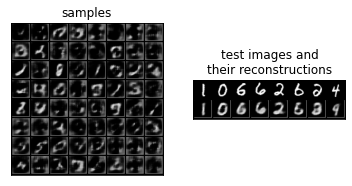

Training epoch 2 [0/60000 (0%)]: loss = 182.379941; bits per pixel = 0.032453; distortion = 164.744199
Training epoch 2 [10000/60000 (17%)]: loss = 174.357930; bits per pixel = 0.032228; distortion = 156.844414
Training epoch 2 [20000/60000 (33%)]: loss = 166.293633; bits per pixel = 0.031992; distortion = 148.908164
Training epoch 2 [30000/60000 (50%)]: loss = 170.359609; bits per pixel = 0.031414; distortion = 153.288125
Training epoch 2 [40000/60000 (67%)]: loss = 164.114023; bits per pixel = 0.032714; distortion = 146.336396
Training epoch 2 [50000/60000 (83%)]: loss = 168.429629; bits per pixel = 0.032082; distortion = 150.995547
Epoch 2 of 50 (14 sec): test bits per pixel = 0.0322; test distortion = 141.7675
Prior log variances: [1.3052444, 1.3385856, 1.4397405, 1.3897202, 1.5508397, 1.2912735, 1.2864964, 1.3887179]
Training epoch 3 [0/60000 (0%)]: loss = 159.723574; bits per pixel = 0.032442; distortion = 142.093965
Training epoch 3 [10000/60000 (17%)]: loss = 159.937881; bits p

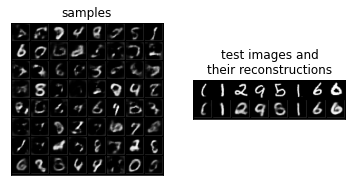

Training epoch 6 [0/60000 (0%)]: loss = 136.357207; bits per pixel = 0.032300; distortion = 118.804365
Training epoch 6 [10000/60000 (17%)]: loss = 137.171553; bits per pixel = 0.032412; distortion = 119.558105
Training epoch 6 [20000/60000 (33%)]: loss = 138.650273; bits per pixel = 0.032919; distortion = 120.761348
Training epoch 6 [30000/60000 (50%)]: loss = 132.996758; bits per pixel = 0.032482; distortion = 115.345166
Training epoch 6 [40000/60000 (67%)]: loss = 134.081338; bits per pixel = 0.033179; distortion = 116.050723
Training epoch 6 [50000/60000 (83%)]: loss = 127.215859; bits per pixel = 0.032706; distortion = 109.442617
Epoch 6 of 50 (17 sec): test bits per pixel = 0.0329; test distortion = 113.6810
Prior log variances: [1.3446616, 1.703564, 1.4328332, 1.7664645, 1.9719734, 1.5870203, 1.5369414, 1.3283496]
Training epoch 7 [0/60000 (0%)]: loss = 132.047764; bits per pixel = 0.033235; distortion = 113.987129
Training epoch 7 [10000/60000 (17%)]: loss = 126.018145; bits pe

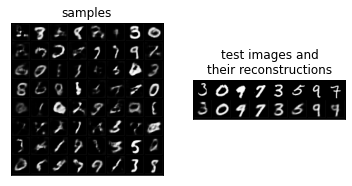

Training epoch 11 [0/60000 (0%)]: loss = 121.694873; bits per pixel = 0.033799; distortion = 103.327656
Training epoch 11 [10000/60000 (17%)]: loss = 122.342852; bits per pixel = 0.033101; distortion = 104.355127
Training epoch 11 [20000/60000 (33%)]: loss = 125.128984; bits per pixel = 0.032633; distortion = 107.395459
Training epoch 11 [30000/60000 (50%)]: loss = 123.321328; bits per pixel = 0.032931; distortion = 105.425947
Training epoch 11 [40000/60000 (67%)]: loss = 129.307334; bits per pixel = 0.032599; distortion = 111.592373
Training epoch 11 [50000/60000 (83%)]: loss = 130.777959; bits per pixel = 0.032511; distortion = 113.110352
Epoch 11 of 50 (17 sec): test bits per pixel = 0.0329; test distortion = 103.8211
Prior log variances: [1.3983212, 1.8184985, 1.2722024, 1.8864233, 2.0457847, 1.6265233, 1.5951648, 1.2708689]
Training epoch 12 [0/60000 (0%)]: loss = 119.348555; bits per pixel = 0.033225; distortion = 101.293311
Training epoch 12 [10000/60000 (17%)]: loss = 122.82974

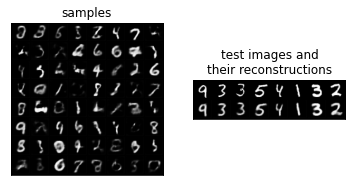

Training epoch 16 [0/60000 (0%)]: loss = 120.860313; bits per pixel = 0.032681; distortion = 103.100391
Training epoch 16 [10000/60000 (17%)]: loss = 119.058711; bits per pixel = 0.032550; distortion = 101.369922
Training epoch 16 [20000/60000 (33%)]: loss = 122.731182; bits per pixel = 0.032672; distortion = 104.976113
Training epoch 16 [30000/60000 (50%)]: loss = 124.834434; bits per pixel = 0.032575; distortion = 107.132129
Training epoch 16 [40000/60000 (67%)]: loss = 116.619805; bits per pixel = 0.032481; distortion = 98.968984
Training epoch 16 [50000/60000 (83%)]: loss = 121.554629; bits per pixel = 0.033029; distortion = 103.605703
Epoch 16 of 50 (17 sec): test bits per pixel = 0.0327; test distortion = 100.7893
Prior log variances: [1.4122719, 1.8619647, 1.1316988, 1.9244542, 2.0728962, 1.6077116, 1.6455019, 1.2369562]
Training epoch 17 [0/60000 (0%)]: loss = 120.957012; bits per pixel = 0.033032; distortion = 103.006309
Training epoch 17 [10000/60000 (17%)]: loss = 125.238105

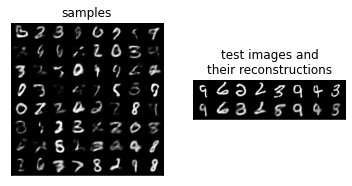

Training epoch 21 [0/60000 (0%)]: loss = 117.596826; bits per pixel = 0.032539; distortion = 99.914502
Training epoch 21 [10000/60000 (17%)]: loss = 118.100859; bits per pixel = 0.032279; distortion = 100.559414
Training epoch 21 [20000/60000 (33%)]: loss = 117.865078; bits per pixel = 0.032606; distortion = 100.146250
Training epoch 21 [30000/60000 (50%)]: loss = 119.614297; bits per pixel = 0.032623; distortion = 101.885918
Training epoch 21 [40000/60000 (67%)]: loss = 109.082754; bits per pixel = 0.032753; distortion = 91.284082
Training epoch 21 [50000/60000 (83%)]: loss = 114.813164; bits per pixel = 0.032251; distortion = 97.287109
Epoch 21 of 50 (17 sec): test bits per pixel = 0.0327; test distortion = 99.5117
Prior log variances: [1.4056445, 1.8552206, 0.98182726, 1.9291195, 2.1183882, 1.5706508, 1.691622, 1.2201549]
Training epoch 22 [0/60000 (0%)]: loss = 116.484746; bits per pixel = 0.032946; distortion = 98.581240
Training epoch 22 [10000/60000 (17%)]: loss = 117.795781; bi

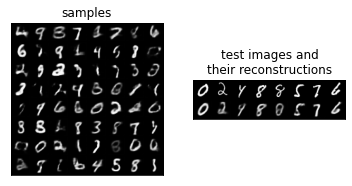

Training epoch 26 [0/60000 (0%)]: loss = 119.598340; bits per pixel = 0.033055; distortion = 101.635488
Training epoch 26 [10000/60000 (17%)]: loss = 118.380391; bits per pixel = 0.032779; distortion = 100.567148
Training epoch 26 [20000/60000 (33%)]: loss = 112.823867; bits per pixel = 0.032580; distortion = 95.119160
Training epoch 26 [30000/60000 (50%)]: loss = 115.268945; bits per pixel = 0.032743; distortion = 97.475420
Training epoch 26 [40000/60000 (67%)]: loss = 112.063359; bits per pixel = 0.032958; distortion = 94.153086
Training epoch 26 [50000/60000 (83%)]: loss = 123.779219; bits per pixel = 0.032478; distortion = 106.129854
Epoch 26 of 50 (17 sec): test bits per pixel = 0.0325; test distortion = 98.4363
Prior log variances: [1.4024308, 1.864182, 0.8071341, 1.9131321, 2.1798234, 1.5351802, 1.7315816, 1.2181036]
Training epoch 27 [0/60000 (0%)]: loss = 116.195430; bits per pixel = 0.032771; distortion = 98.386914
Training epoch 27 [10000/60000 (17%)]: loss = 117.406582; bit

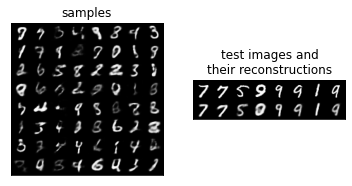

Training epoch 31 [0/60000 (0%)]: loss = 115.855264; bits per pixel = 0.032503; distortion = 98.192051
Training epoch 31 [10000/60000 (17%)]: loss = 117.270166; bits per pixel = 0.032912; distortion = 99.384824
Training epoch 31 [20000/60000 (33%)]: loss = 118.399121; bits per pixel = 0.032619; distortion = 100.673271
Training epoch 31 [30000/60000 (50%)]: loss = 114.681279; bits per pixel = 0.032583; distortion = 96.974717
Training epoch 31 [40000/60000 (67%)]: loss = 120.761221; bits per pixel = 0.032618; distortion = 103.035879
Training epoch 31 [50000/60000 (83%)]: loss = 115.134014; bits per pixel = 0.032944; distortion = 97.231562
Epoch 31 of 50 (17 sec): test bits per pixel = 0.0324; test distortion = 97.9494
Prior log variances: [1.3999403, 1.8689353, 0.6543412, 1.921155, 2.2354107, 1.5286963, 1.7875351, 1.2187665]
Training epoch 32 [0/60000 (0%)]: loss = 116.102852; bits per pixel = 0.032716; distortion = 98.324072
Training epoch 32 [10000/60000 (17%)]: loss = 117.769629; bits

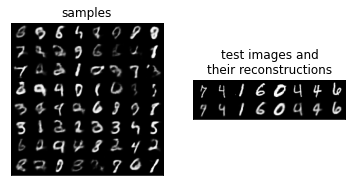

Training epoch 36 [0/60000 (0%)]: loss = 118.623496; bits per pixel = 0.032657; distortion = 100.876543
Training epoch 36 [10000/60000 (17%)]: loss = 112.611611; bits per pixel = 0.032169; distortion = 95.130029
Training epoch 36 [20000/60000 (33%)]: loss = 112.303916; bits per pixel = 0.032449; distortion = 94.670332
Training epoch 36 [30000/60000 (50%)]: loss = 114.899541; bits per pixel = 0.032647; distortion = 97.158340
Training epoch 36 [40000/60000 (67%)]: loss = 119.201787; bits per pixel = 0.032481; distortion = 101.550957
Training epoch 36 [50000/60000 (83%)]: loss = 121.467334; bits per pixel = 0.032574; distortion = 103.765898
Epoch 36 of 50 (17 sec): test bits per pixel = 0.0324; test distortion = 97.6447
Prior log variances: [1.4129555, 1.893756, 0.58424276, 1.9186893, 2.2666104, 1.515843, 1.8282319, 1.2124877]
Training epoch 37 [0/60000 (0%)]: loss = 116.263193; bits per pixel = 0.032685; distortion = 98.501475
Training epoch 37 [10000/60000 (17%)]: loss = 113.915000; bit

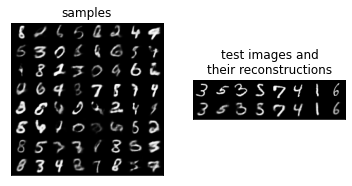

Training epoch 41 [0/60000 (0%)]: loss = 115.439531; bits per pixel = 0.032642; distortion = 97.700850
Training epoch 41 [10000/60000 (17%)]: loss = 117.310381; bits per pixel = 0.033253; distortion = 99.240049
Training epoch 41 [20000/60000 (33%)]: loss = 120.180830; bits per pixel = 0.032427; distortion = 102.559004
Training epoch 41 [30000/60000 (50%)]: loss = 117.618896; bits per pixel = 0.032725; distortion = 99.835313
Training epoch 41 [40000/60000 (67%)]: loss = 112.614639; bits per pixel = 0.032682; distortion = 94.854551
Training epoch 41 [50000/60000 (83%)]: loss = 117.100645; bits per pixel = 0.032221; distortion = 99.591074
Epoch 41 of 50 (17 sec): test bits per pixel = 0.0324; test distortion = 97.0315
Prior log variances: [1.393694, 1.871015, 0.5146806, 1.9106141, 2.286457, 1.5138818, 1.8511113, 1.1993238]
Training epoch 42 [0/60000 (0%)]: loss = 117.070254; bits per pixel = 0.032360; distortion = 99.485146
Training epoch 42 [10000/60000 (17%)]: loss = 115.352051; bits pe

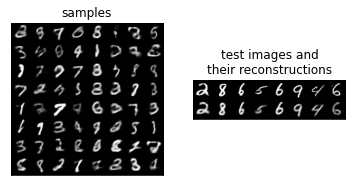

Training epoch 46 [0/60000 (0%)]: loss = 110.915322; bits per pixel = 0.031994; distortion = 93.528789
Training epoch 46 [10000/60000 (17%)]: loss = 115.537646; bits per pixel = 0.032610; distortion = 97.816396
Training epoch 46 [20000/60000 (33%)]: loss = 114.429121; bits per pixel = 0.032743; distortion = 96.635801
Training epoch 46 [30000/60000 (50%)]: loss = 110.921533; bits per pixel = 0.032509; distortion = 93.254990
Training epoch 46 [40000/60000 (67%)]: loss = 121.359629; bits per pixel = 0.032269; distortion = 103.823857
Training epoch 46 [50000/60000 (83%)]: loss = 111.445859; bits per pixel = 0.032474; distortion = 93.798789
Epoch 46 of 50 (17 sec): test bits per pixel = 0.0325; test distortion = 96.7124
Prior log variances: [1.3872094, 1.8921361, 0.48828885, 1.9118018, 2.3207312, 1.5256714, 1.8787769, 1.2141154]
Training epoch 47 [0/60000 (0%)]: loss = 117.875967; bits per pixel = 0.032345; distortion = 100.298730
Training epoch 47 [10000/60000 (17%)]: loss = 114.023682; bi

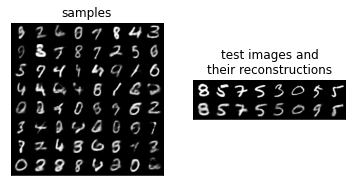

In [16]:
BETA = 1.0 # TODO: change this to different values and observe the rate-distortion trade-off

torch.manual_seed(RANDOM_SEED)

def reset_parameters(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

encoder.apply(reset_parameters)
decoder.apply(reset_parameters)
prior_log_variance = torch.nn.Parameter(torch.ones((LATENT_DIM,))) 

encoder = Encoder().to(device)
decoder = Decoder().to(device)
prior_log_variance = prior_log_variance.to(device)
if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder)
    decoder = nn.DataParallel(decoder)

# Note that `prior_log_variance` is now also part of the parameters over
# which we optimize:
learnable_parameters = list(encoder.parameters()) + list(decoder.parameters()) + [prior_log_variance]
optimizer = optim.Adam(learnable_parameters, lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    show_plots = epoch == 1 or epoch % 5 == 0  

    train(epoch, BETA)
    test_bitrate, test_distortion, x_hat = test(render_reconstructions=show_plots)
    end_time = time.time()
    print(
        f'Epoch {epoch} of {EPOCHS} ({end_time - start_time:.0f} sec): ' +
        f'test bits per pixel = {test_bitrate/ (np.log(2) * 28**2):.4f}; ' +
        f'test distortion = {test_distortion:.4f}'
    )
    print(f'Prior log variances: {[i for i in prior_log_variance.cpu().detach().numpy()]}')

    if show_plots:
        figure, samples_plot, reconstructions_plot = create_figure()
        with torch.no_grad():
            sample = (torch.exp(0.5 * prior_log_variance) * torch.randn(64, LATENT_DIM)).to(device)
            sample = decoder(sample).cpu()
            samples_plot.imshow(make_grid(sample.view(64, 1, 28, 28)).permute((1, 2, 0)))
        reconstructions_plot.imshow(x_hat)
        plt.show()

## Outlook: Entropy Coding

So far, we've only implemented a model that *could* be used for lossy compression, but we haven't actually produced any compressed bit strings.
Producing the compressed bit strings isn't hard (assuming you use a library for the actual entropy coding task, such as our [`constriction` library](https://bamler-lab.github.io/constriction/)).
However, dealing with bit strings still brings along a few technicalities that would distract from the fundamentals that this problem is trying to teach.

We'll defer the actual task of encoding and decoding to and from a bit string to the next problem set.